<a href="https://colab.research.google.com/github/WhackyBoyg0d/NaiveBayes/blob/main/NaiveBayes_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP3314B Programming Assignment 1

## Due: March 24, 2023 at 6:00 a.m.

Welcome to our first programming assignment! Here are six programming tasks in total and all the parts you need to code are wrapped by comments like

```python
def some_func():
    ...
    # Requirements:
    # 1. Your code should ...
    ######## your code starts here ########


    ######## your code ends here   ########
    ....
```

Have fun with this notebook!

We recommend you to use either [Colab](https://colab.research.google.com/) or your own local Python environment for this programming assignment.

- To set up the Colab environment, you need to open https://colab.research.google.com/ and click `File -> Open notebook -> upload the provided notebook file`. There are many online [tutorials](https://colab.research.google.com/notebooks/basic_features_overview.ipynb) for Colab, which you could refer to for relevant information.
- It is also OK to use your own native environment. Note that your Python version should be higher than 3.6 with [NumPy](https://numpy.org/install/) and [Matplotlib](https://matplotlib.org/) packages installed.

You do not need to write a report; just write codes and add text blocks in the notebook appropriately. Submit your notebook in `.ipynb` format (**with all outputs saved**) to Moodle. To export your notebook in Colab, simply click `File -> Download -> Download .ipynb` on your Colab tab.

# Task: Naive Bayes Classifiers

In this assignment, you will use NumPy to build a simple Naive Bayes Classifier (NBC) to solve a toy classification problem.

### Basic environment setup

In [ ]:
# Basic setup
import numpy as np
# this line is only used for presenting the results in a more readable way
np.set_printoptions(precision=3)

# set the seed for the random number generator
# this is only used for reproducibility of the results
np.random.seed(seed=3314)

# matplotlib is used to plot/visualize things
import matplotlib.pyplot as plt # import matplotlib.pyplot for plotting figures
plt.style.use('ggplot') # use "ggplot" style for graphs

### Create a toy dataset

We will use the same data creation strategy in our first tutorial. The toy dataset $D = \{(\boldsymbol{x}_n, y_n)\}_{n=1}^N$ consists of $N$ data points, with $\boldsymbol{x}_n \in \mathbb{R}^2$ being the feature vector and $y_n \in \{0,1,2\}$ being the label.

For illustration purpose, let us assume that any $\boldsymbol{x}_n$ would follow $\mathcal{N}(\mu_c, \Sigma_c)$ if $y_n = c$ with $c = 0,1,2$. That is, the data points with the same label would follow the same Gaussian distribution.


In [ ]:
def create_toy_data(mus, Sigmas, Ns):
    x = []
    y = []
    for c, (mu, Sigma, N) in enumerate(zip(mus, Sigmas, Ns)):
        # sample from these Gaussian distributions to create toy data features
        # returns numpy arrays with shape [N, 2]
        x_class_c = np.random.multivariate_normal(mu, Sigma, size=N)
        # create corresponding labels
        # .astype(int) converts the data type to integer
        y_class_c = np.full(N, fill_value=c).astype(int)

        # store the data points and labels for each class
        x.append(x_class_c)
        y.append(y_class_c)

    # we concat the arrays
    # for the data point x, it has shape [N_1 + N_2 + ... + N_C, 2]
    # for the label y, it has shape [N]
    return np.concatenate(x, axis=0), np.concatenate(y, axis=0)

Run the following code to see how the data points are distributed in the 2D space.

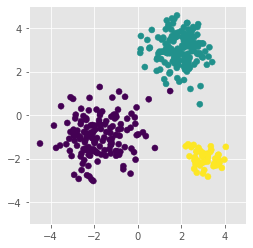

In [ ]:
# load dataset
mu_0 = [-1.8, -1.0]
mu_1 = [2.0, 3.0]
mu_2 = [3.0, -2.0]
Sigma_0 = [
            [0.8, 0.0],
            [0.0, 0.8]
          ]
Sigma_1 = [
            [0.5, 0.0],
            [0.0, 0.5]
          ]
Sigma_2 = [
            [0.2, 0.0],
            [0.0, 0.2]
          ]
N_0 = 150
N_1 = 150
N_2 = 50

# store the parameters in a list
mus = [mu_0, mu_1, mu_2]
Sigmas = [Sigma_0, Sigma_1, Sigma_2]
Ns = [N_0, N_1, N_2]

num_classes = 3 # number of classes
D = 2 # dimensionality of the data
x_train, y_train = create_toy_data(mus, Sigmas, Ns)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

---

### Univariate Gaussian distribution

Recall the probability density function (pdf) of a univariate Gaussian (or normal) distribution is defined as
$$
p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left ({-\frac{1}{2\sigma^2}(x - \mu)^2} \right).
$$
Sometimes it is denoted by $\mathcal{N}(x;\mu,\sigma^2)$. A univariate Gaussian distribution has two parameters:
- $\mu$, which encodes the mean value and controls the localtion;
- $\sigma$, whose square $\sigma^2$ encodes the variance and controls the scale.


## Task 1: calculate the pdf of univariate Gaussian distributions (10 points)

In this task, you need to use NumPy to implement a function that calculates the pdf of univariate Gaussians, given some data point $x$ and the corresponding parameters $(\mu, \sigma)$.

Typically, we assume the input x is a vector of $N$ data points, and the output is a vector of $N$ density values evaluated at corresponding points. The parameters $\mu$ and $\sigma$ are scalars.

- A good practice is to try to [vectorize](https://en.wikipedia.org/wiki/Array_programming) the code as much as possible and avoid sequential operations (e.g., loops). Nevertheless, full remarks will be received as long as the result is correct.

In [ ]:
# the function to compute the pdf of p(x; \mu, \sigma)
def univariate_gaussian_density(x, mu, sigma):
    """
    Returns the univariate Gaussian density function evaluated at x,
    with parameters mu and sigma.
q
    x: x.shape == [N], where N is the number of data points.
    mu: scalar, indicating the mean of the Gaussian.
    sigma: scalar, indicating the standard deviation of the Gaussian.

    return
    y: y.shape == [N], where N is the number of data points.
        y is the pdf of p(x; \mu, \sigma) evaluated at each point in x.
    """
    #### Your code starts here #####
    y = (1/np.sqrt(2*np.pi*(sigma*sigma)))*np.exp((-1/(2*sigma*sigma))*(x-mu)*(x-mu))
    return y
    #### Your code ends here #####

If your implementation is correct, running the following code block should produce a figure similar to this, which visualizes 3 different Gaussian distributions with different parameters.

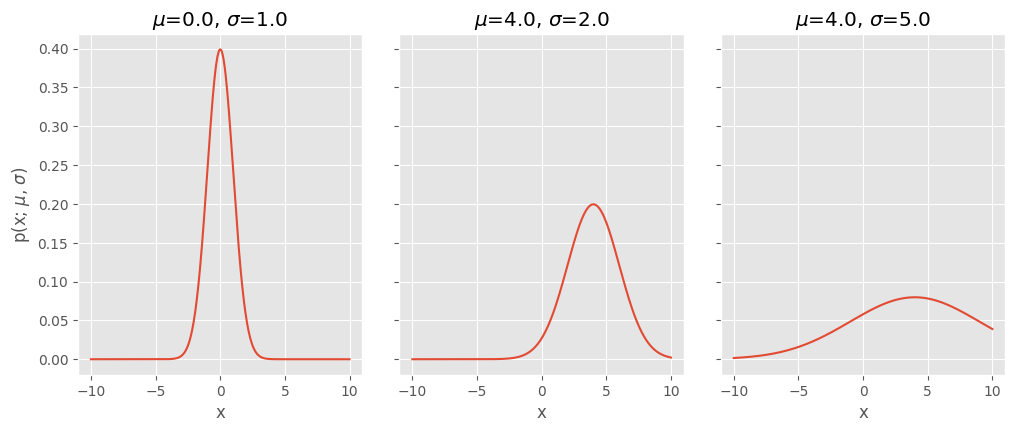

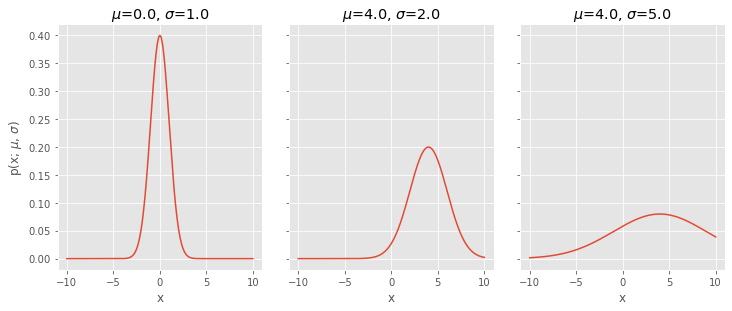

In [ ]:
def plot_univariate_gaussian():
    _mus_and_simgas = [(0, 1), (4, 2), (4, 5)]

    # plotting utilities
    # create a figure with 1 rows and 3 columns with proper spacing
    fig, ax = plt.subplots(1,len(_mus_and_simgas), figsize=(10,4), sharey=True) #placeholders for 2 row x 2 columns images
    fig.tight_layout() # automatically adjusts spacing of subplots.
    x = np.linspace(-10, 10, 500) # generate 500 evenly placed values of x from -10 to 10
    for i in range(len(_mus_and_simgas)):
        mu, sigma = _mus_and_simgas[i]
        # Gaussian distribution with parameter (mu, sigma)
        ax[i].plot(x, univariate_gaussian_density(x, mu, sigma))
        ax[i].set_title(f'$\\mu$={mu:.1f}, $\\sigma$={sigma:.1f}')
        if i == 0:
            ax[i].set_ylabel('p(x; $\mu$, $\sigma$)')
        ax[i].set_xlabel('x')
    plt.show()

plot_univariate_gaussian()

### Multivariate Gaussian distribution

The pdf of the multivariate Gaussian for a $D$-dimensional variable $X$ is
$$
p(x; \mu, \Sigma) = \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}\exp \left ({-\frac{1}{2}(x - \mu)^\top \Sigma^{-1} (x - \mu)} \right).
$$
It has two sets of parameters:
- $\mathbf{\mu} \in \mathbb{R}^D$, encoding the mean for each dimensionality;
- $\Sigma \in \mathbb{R}^{D \times D}$ is the covariance matrix which is analogous to the variance $\sigma^2$; however, it not only the scale of each dimensionality, but also encodes the relationship between two dimensions. Each element $\Sigma_{i,j}$ is the covariance for dimensions $i$ and $j$ : $\Sigma_{i,j} = \operatorname{Cov}(X_i,X_j) = \mathbb{E}[(X_i-\mathbb{E}[X_i])(X_j-\mathbb{E}[X_j])]$.

### Diagonal covariance matrix

Here, we consider a special case where the covariance matrix $\Sigma$ is diagonal, i.e., $\Sigma = \operatorname{diag}(\sigma_1^2, \sigma_2^2, \ldots, \sigma_D^2)$. In this case, the pdf of the multivariate Gaussian is
$$
\begin{aligned}
p(x; \mu, \Sigma) &= \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}\exp \left ({-\frac{1}{2}(x - \mu)^\top \Sigma^{-1} (x - \mu)} \right) \\
&= \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}}\exp \left ({-\frac{1}{2}\sum_{i=1}^D \frac{(x_i - \mu_i)^2}{\sigma_i^2}} \right) \\
&= \frac{1}{(2\pi)^{D/2}\prod_{i=1}^D \sigma_i}\exp \left ({-\frac{1}{2}\sum_{i=1}^D \frac{(x_i - \mu_i)^2}{\sigma_i^2}} \right) \\
&= \prod_{i=1}^D \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp \left ({-\frac{1}{2\sigma_i^2}(x_i - \mu_i)^2} \right).
\end{aligned}
$$

Therefore, the pdf of the multivariate Gaussian with diagonal covariance matrix is simply a **product** of $D$ univariate Gaussian distributions.

## Task 2: calculate the pdf of diagonal multivariate Gaussians (5 points)

Implement a function that calculates the pdf of multi-variate Gaussian distributions, given some $d$-dimensional data point $x$ and the corresponding parameters $(\boldsymbol{\mu}, \Sigma)$. Assume the covariance matrix is diagonal.

In [ ]:
# the function to compute the pdf of p(x; \mu, \sigma)
def multivariate_diagonal_gaussian_density(x, mu, sigma):
    """
    Returns the multivariate Gaussian density function evaluated at x,
    with parameters mu and sigma.

    x: x.shape == [N, D], where N is the number of data points and D is the dimensionality of the data.
    mu: mu.shape == [D], where D is the dimensionality of the data.
    sigma: sigma.shape == [D, D], where D is the dimensionality of the data.
           Here we assume that the covariance matrix is diagonal, i.e. sigma[i, j] = 0 if i != j.

    return
    y: y.shape == [N], where N is the number of data points.
       y is the pdf of p(x; \mu, \sigma) evaluated at each point in x.
    """
    #### Your code starts here #####
    y = []
    for i in x:
        y.append(univariate_gaussian_density(i[0], mu[0], sigma[0][0]) * univariate_gaussian_density(i[1], mu[1], sigma[1][1]))
    return np.array(y)
    #### Your code ends here #####

If your implementation is correct, running the following code block should produce a figure similar to this one, which visualizes 3 different multivariate Gaussian distributions with different parameters.

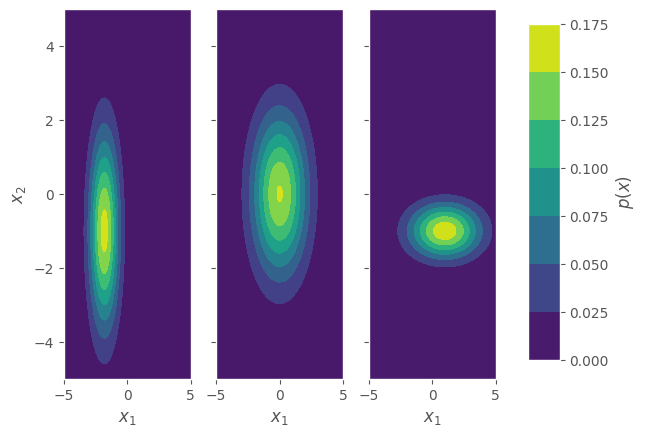

C:\Users\Aditya\AppData\Local\Temp\ipykernel_37792\1659083623.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(img, cax=cbar_ax)


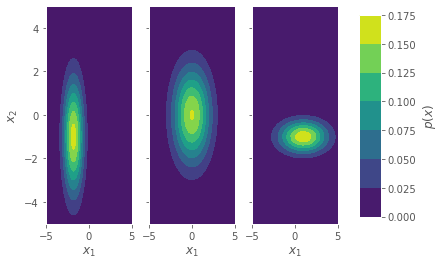

In [ ]:
def plot_multivariate_gaussian():
    mu_0 = [-1.8, -1.0]
    mu_1 = [0.0, 0.0]
    mu_2 = [1.0, -1.0]
    Sigma_0 = [
                [0.8, 0.0],
                [0.0, 1.8]
            ]
    Sigma_1 = [
                [1.5, 0.0],
                [0.0, 1.5]
            ]
    Sigma_2 = [
                [1.9, 0.0],
                [0.0, 0.5]
            ]
    # store the parameters in a list
    mus = np.array([mu_0, mu_1, mu_2])
    Sigmas = np.array([Sigma_0, Sigma_1, Sigma_2])

    fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
    # build 2D grid
    x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    x = np.stack([x1, x2], axis=-1).reshape(10000, 2)
    for i, ax in enumerate(axes):
        z = multivariate_diagonal_gaussian_density(x, mus[i], Sigmas[i])
        img = ax.contourf(x1, x2, z.reshape(100, 100))
        ax.set_xlabel("$x_1$")
        if i == 0:
            ax.set_ylabel("$x_2$")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_label("$p(x)$")
    plt.show()

plot_multivariate_gaussian()

---

### Naive Bayes Classifiers (NBCs): an overview

Naive Bayes classifiers are a kind of generative classifiers, which not only models the **class posterior distribution** $p(y|\boldsymbol{x};\boldsymbol{\theta})$ for prediction, but also models the **class conditional probability** $p(\boldsymbol{x}|y;\boldsymbol{\theta})$.

To clarify the **prior** and **posterior** distributions:
- the class **prior** distribution is denoted by $p(y;\boldsymbol{\pi})$; it encodes our prior belief about the class probalitiy $\pi$ without the knowledge of $\boldsymbol{x}$;
- the class **posterior** distribution is $p(y|\boldsymbol{x};\boldsymbol{\theta})$; it reflects our updated belief about the class probability after observing $\boldsymbol{x}$.


### Formulation

The main idea of NBC models is to impose **conditional independence** on the class conditional probability density $p(\boldsymbol{x}|y;\boldsymbol{\theta})$. In other words, the feature dimensions are independent of each other conditional on the class variable $y$. Supposing $y=c$, we have
$$
 p(\boldsymbol{x}|y=c;\boldsymbol{\theta}) = \prod_{d=1}^D p(x_{d}|y=c;\boldsymbol{\theta}_{dc}).
$$

### Maximum Likelihood Estimation (MLE)

All data points in the dataset $D = \{(\boldsymbol{x}_n, y_n)\}_{n=1}^N$ are assumed i.i.d. (**independent** and identically distributed). If we denote $\boldsymbol{x}_{nd}$ as the $d$-th dimension of the $n$-th data point, this further means
$$
\begin{aligned}
p(D;\boldsymbol{\theta}) &= \prod_{n=1}^N p(\boldsymbol{x}_n, y_n|\boldsymbol{\theta})\\
&= \prod_{n=1}^N p(y_n;\boldsymbol{\pi}) p(\boldsymbol{x}_n|y_n;\boldsymbol{\theta})\\
&= \prod_{n=1}^N p(y_n;\boldsymbol{\pi}) \prod_{d=1}^{D} p\left(x_{nd} | y_n, \boldsymbol{\theta}_{d y_n}\right).
\end{aligned}
$$

We fit the model via maximum likelihood estimation for the joint distribution over $x$ and $y$. The negative log likelihood (NLL) function is
$$
\begin{aligned}
-\log p(D;\boldsymbol{\theta}) &= -\log\prod_{n=1}^N p(y_n;\boldsymbol{\pi}) \prod_{d=1}^{D} p\left(x_{nd} | y_n, \boldsymbol{\theta}_{d y_n}\right) \\
&= -\left(\sum_{n=1}^N \log p(y_n;\boldsymbol{\pi}) + \sum_{n=1}^N \log p\left(x_{nd} | y_n, \boldsymbol{\theta}_{d y_n}\right)\right).
\end{aligned}
$$
Our goal is to estimate $\boldsymbol{\pi}$ and $\boldsymbol{\theta}$. Since the log likelihood functions involving $\boldsymbol{\pi}$ and $\boldsymbol{\theta}$ are decoupled, we could estimate them individually via maximum likelihood estimation. In addition, they would typically have closed-form solutions, as we see below.

In this case, we have real-valued features ($x_d \in \mathbb{R}$ for each $d$). A suitable way is to model each feature dimension through a univariate Gaussian distribution $p(x_d|y=c;\boldsymbol{\theta}_{dc}) = \mathcal{N}(x_d|\mu_{dc}, \sigma^2_{dc})$.

Thus in our NBC model, there are three sets of parameters:
- $\boldsymbol{\pi}$: a $C$-dimensional vector, each dimension of which corresponds to the prior class probability. According to the lecture and textbook, this actually defines a categorical distribution and its parameter can be estimated as (denote $N_c$ as the number of data points for class $c$ and $N$ is the total number of data points)
$$
\widehat{\pi}_{c}=\frac{N_{c}}{N}.
$$
- $\boldsymbol{\mu}$: the mean of each class conditional density. It consists of $C$ vectors for each class and each vector is $D$-dimensional; for Gaussian distributions, it is known that the MLE for mean is
$$
\widehat{\mu}_{d c} =\frac{1}{N_{c}} \sum_{n: y_{n}=c} x_{n d}.
$$
- $\boldsymbol{\sigma}$: the standard deviation of each class conditional density. It consists of $C$ vectors for each class and each vector is $D$-dimensional. The MLE for the variance is
$$
\widehat{\sigma}_{d c}^{2} =\frac{1}{N_{c}} \sum_{n: y_{n}=c}\left(x_{n d}-\widehat{\mu}_{d c}\right)^{2}.
$$

## Task 3: Implement Maximum Likelihood Estimation (MLE) (45 points)

In this task, you need to implement the maximum likelihood estimation (MLE) above for the parameters of the naive Bayes classifier, including
- the parameter $\pi$ of the class prior probability (15 points);
- the parameters $(\mu, \sigma)$ of the Gaussian distribution (30 points in total, 15 points for each);

In [ ]:
# estimate parameter pi for prior class probability
def estimate_pi(y, num_classes):
	"""
	Returns the prior class probability, pi, estimated from the data labels.

	y: y.shape == [N], where N is the number of data points.
	num_classes: the number of classes.

	return
	estimated_pi: estimated_pi.shape == [num_classes]
	"""
	N = y.shape[0] # the total number of data points
	estimated_pi = np.zeros(num_classes)
    #### Your code starts here #####
	# ....
	dict = {}
	for i in y:
		if i in dict:
			dict[i] += 1
		else:
			dict[i] = 1
	k = 0
	for r in dict:
		estimated_pi[k] = dict[r]/N
		k+=1
	return estimated_pi
    #### Your code ends here #####


# estimate parameter theta = (mu, sigma) for class conditional probability
def estimate_theta(x, y, num_classes):
	"""
	Returns the class conditional probability parameters, theta, estimated from the data.

	x: x.shape == [N, D], where N is the number of data points and D is the dimensionality of the data.
	y: y.shape == [N], where N is the number of data points.
	num_classes: the number of classes.

	return
	estimated_mu: estimated_mu.shape == [num_classes, D]
	estimated_Sigma: estimated_Sigma.shape == [num_classes, D, D]
	"""
	D = x.shape[1]
	# initialize the mu and Sigma parameter.
	estimated_mu = np.zeros((num_classes, D))
	# initialize a 3D ``matrix'' to store the covariance matrix for each class.
	estimated_Sigma = np.zeros((num_classes, D, D))

    #### Your code starts here #####
	# ....
	N = y.shape[0]
	dict = {}
	for i in y:
		if i in dict:
			dict[i] += 1
		else:
			dict[i] = 1
	k=0
	for r in dict:
		class_mu = np.zeros(D)
		for j in range(N):
			if y[j]==r:
				class_mu+=x[j]
		estimated_mu[k] = class_mu/dict[r]
		k+=1
	t=0
	for r in dict:
		class_sigma = np.zeros(D)
		xc = []
		for j in range(N):
			if y[j]==r:
				xc.append(x[j])
		xc = np.array(xc)
		estimated_Sigma[t] = np.diag(((1/dict[r])*np.sum((xc - estimated_mu[t])**2, axis = 0)))
# 		class_sigma = class_sigma/dict[r]
# 		class_sigma = np.diag(class_sigma)
# 		estimated_Sigma[t] = class_sigma/dict[r]
		t+=1
	return estimated_mu, estimated_Sigma
    #### Your code ends here #####

The following code block checks your implementation. If your implementation is correct,
- your estimated $\boldsymbol{\pi}$ should be the same as the true prior probabilities;
- the estimated $\boldsymbol{\mu}$, and $\boldsymbol{\Sigma}$ should be close to their true values, respectively.
- But it is also OK if they are not exactly the same, especially for $\boldsymbol{\Sigma}$.

In [ ]:
_estimated_pi = estimate_pi(y_train, num_classes)

_estimated_mu, _estimated_Sigma = estimate_theta(x_train, y_train, num_classes)

# print relevant information
N = N_0 + N_1 + N_2
true_pi = np.array([N_0/N, N_1/N, N_2/N])
print("Estimated pi: {}, true class prior probability : {}\n".format(_estimated_pi, true_pi))
for class_c in range(num_classes):
	print("=====> Class {}".format(class_c))
	estimated_mu_class_c = _estimated_mu[class_c].tolist()
	print("Estimated mu: {}, true mu: {}".format(estimated_mu_class_c, mus[class_c]))

	estimated_Sigma_class_c = _estimated_Sigma[class_c].tolist()
	print("Estimated Sigma: {}, true Sigma: {}".format(estimated_Sigma_class_c, Sigmas[class_c]))

Estimated pi: [0.429 0.429 0.143], true class prior probability : [0.429 0.429 0.143]

=====> Class 0
Estimated mu: [-1.766255877120642, -0.9657375362692885], true mu: [-1.8, -1.0]
Estimated Sigma: [[1.001294295473416, 0.0], [0.0, 0.7989117597824231]], true Sigma: [[0.8, 0.0], [0.0, 0.8]]
=====> Class 1
Estimated mu: [1.9542348799577853, 3.0335491266020167], true mu: [2.0, 3.0]
Estimated Sigma: [[0.47917222624387973, 0.0], [0.0, 0.5521666465284824]], true Sigma: [[0.5, 0.0], [0.0, 0.5]]
=====> Class 2
Estimated mu: [3.1144187537048036, -1.9880082531221999], true mu: [3.0, -2.0]
Estimated Sigma: [[0.21231837676015328, 0.0], [0.0, 0.12516900066285705]], true Sigma: [[0.2, 0.0], [0.0, 0.2]]


### Prediction
After fitting an NBC model, we would like to predict the label of unseen data points $(\boldsymbol{x}, y)$.

In particular, we would like to compute the posterior class probability based on Bayes' theorem
$$
\begin{aligned}
p(y=c | \boldsymbol{x}; \boldsymbol{\theta}) &= \frac{p(\boldsymbol{x}, y=c;\boldsymbol{\theta})}{p(\boldsymbol{x};\boldsymbol{\theta})} \\
&= \frac{p(y=c;\boldsymbol{\pi})p(\boldsymbol{x}|y=c;\boldsymbol{\theta})}{\sum_{c'} p(y=c';\boldsymbol{\pi})p(\boldsymbol{x}|y=c;\boldsymbol{\theta})} \\
&= \frac{p(y=c ; \boldsymbol{\pi}) \prod_{d=1}^{D} p\left(x_{d} | y=c; \boldsymbol{\theta}_{d c}\right)}{\sum_{c^{\prime}} p\left(y=c^{\prime} ; \boldsymbol{\pi}\right) \prod_{d=1}^{D} p\left(x_{d} | y=c^{\prime}; \boldsymbol{\theta}_{d c^{\prime}}\right)}.
\end{aligned}
$$
By simply comparing the posterior probability of each class, we could **predict the label by assigning it to the class with the largest probability.**

## Task 4: Implement naive Bayes classifier prediction (20 points)


The Naive Bayes Classifier (NBC) implementation follows a similar style as our `LogisticRegression` model in our previous tutorial:
- Training is handled by the `fit()` method, which takes in the training data and labels and estimates the model parameters via your MLE implementation.
- **Your task is to implement its `predict()` method, which predicts the label of given test data points.**

In [ ]:
class NaiveBayesClassifier(object):
	'''
	Naive Bayes Classifier

	'''
	def __init__(self, num_classes, D):
		self.num_classes = num_classes
		self.D = D
		# initialize the parameters
		self.pi = np.zeros(num_classes)
		self.mu = np.zeros((num_classes, D))
		self.sigma = np.zeros((num_classes, D))

	def fit(self, x, y):
		"""
		Fit the model parameters from the data features and labels.

		x: x.shape == [N, D], where N is the number of data points and D is the dimensionality of the data.
		y: y.shape == [N], where N is the number of data points.

		computes
		self.pi: self.pi.shape == [num_classes]
		self.mu: self.mu.shape == [num_classes, D]
		self.sigma: self.sigma.shape == [num_classes, D]
		"""
		self.pi = estimate_pi(y, self.num_classes)
		self.mu, self.sigma = estimate_theta(x, y, self.num_classes)


	def predict(self, x):
		"""
		Predict the class labels for the input data features.

		x: x.shape == [M, D], where M is the number of test data points and D is the dimensionality of the data.

		returns
		y_pred: y_pred.shape == [M], the predicted labels for each data point.
				It should be an integer in {0, 1, ..., num_classes-1}.

		NOTE: the estimated parameters are stored in self.pi, self.mu, and self.sigma, respectively.
		"""
	    #### Your code starts here #####
		y_pred = []
		for i in x:
			den = 0
			for j in range(self.num_classes):
				entry = self.pi[j]
				for k in range(len(i)):
					entry = entry * ((1/np.sqrt(2*np.pi*(self.sigma[j][k][k])))*np.exp((-1/(2*self.sigma[j][k][k]))*(i[k]-self.mu[j][k])**2))
				den+=entry
			val = 0
			class1 = 0
			for j in range(self.num_classes):
				val_curr = self.pi[j]
				for k in range(len(i)):
					val_curr = val_curr * ((1/np.sqrt(2*np.pi*self.sigma[j][k][k]))*np.exp((-1/(2*self.sigma[j][k][k]))*(i[k]-self.mu[j][k])**2))
				val_curr = val_curr/den
				if val_curr > val:
					val = val_curr
					class1 = j
			y_pred.append(class1)
		y_pred = np.array(y_pred)
		return y_pred
		#### Your code ends here #####

Our test set will be all the points in the 2D discretized grid spanning over $[-5, 5] \times [-5, 5]$. Although this is not a realistic scenario, it is a good way to visualize the decision boundary of the classifier. We provide an implementation of the test logic in the `test_model()` method, which also visualizes the prediction for each data point over the grid.

Note that
- `test_model()` invokes your implemented `predict()` function to predict the labels for all test data points.

In [ ]:
def test_model(model):
    # build 2D grid
    x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    x_test = np.stack([x1_test, x2_test], axis=-1).reshape(10000, 2)

    # call the `predict()` method to
    # predict the label for each test data point.
    y_predicted = model.predict(x_test)

    # plot the prediction result
    pc = plt.contourf(x1_test, x2_test, y_predicted.reshape(100,100), alpha=0.2)

    # also plot the original data points
    plt.scatter(x_train[:,0], x_train[:,1], c=y_train)

    # set equal scale for both x/y axis
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

You can run the following code block to fit your NBC model and perform prediction. If your implementation is correct, the trained NBC model should be able to successfully classify the data points.

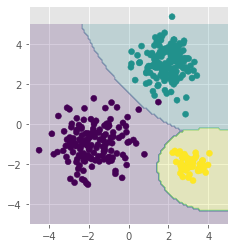

In [ ]:
# initialize the model with proper arguments
model = NaiveBayesClassifier(num_classes, D)
# train the model
model.fit(x_train,y_train)
# test the model using the same method as in logistic regression.
test_model(model)

## Task 5: Is the decision boundary **linear** or **quadratic**? Why? (10 points)

According to the plotted figure, describe whether the decision boundary of naive Bayes classifiers is linear or quadratic (7 points), and explain why this is the case using one or two sentences (3 points). (Hint: you may want to refer to the lecture Slide 3)

`Your explanation starts here: According to the plotted figure, the decision boundary of naive Bayes classifiers is quadratic as the plotted figure implies a quadratic equation in x. This is the case beacsue the diagnol covariance matrix is not shared among all the classes.`

---

### Generative nature of naive Bayes classifiers

Naive Bayes classifiers (NBCs) are a special type of generative classifiers, because they allow you to obtain a estimated prior probability $p(y;\boldsymbol{\pi})$ as well as class conditional probability $p(\boldsymbol{x}|y;\boldsymbol{\theta})$. These can be used to **generate** new data points ($\boldsymbol{x}$, $y$) from the model.

For example, since we have obtained the mean $\boldsymbol{\mu}$ and covariance $\boldsymbol{\Sigma}$ for each class in our `fit()` function, we could directly sample from these distributions to **generate** new data points. In particular, the generation process is as follows:
1. Sample a class label $y = c$ from the prior distribution $p(y;\boldsymbol{\pi})$.
2. Sample a feature $x$ from the class conditional distribution $p(x|y=c;\boldsymbol{\theta}_{c}) = \mathcal{N}(x|\mu_{c}, \Sigma_{c})$.

## Task 6: Implement the generative naive Bayes classifier (10 points)

In this task, you need to implement the generative process from the trained NBC model by completing the `generate_from_nbc()` method. Given the estimated parameters, write a code snippet to sample $N$ new data points $(x,y)$ from the NBC model.

- Hint: you may want to refer to the `create_toy_data(mus, Sigmas, Ns)` function above for some details.

In [ ]:
# REQUIREMENT: write a code snippet to generate new data pairs (x,y) from the estimated parameters.
# The generated data points should look similar to the original data points.
def generate_from_nbc(estimated_pi, estimated_mu, estimated_Sigmas, N):
    """
    Generate new data points from the estimated parameters.

    estimated_pi: estimated_pi.shape == [num_classes]
    estimated_mu: estimated_mu.shape == [num_classes, D]
    estimated_Sigmas: estimated_Sigmas.shape == [num_classes, D, D]
    N: the number of new data points to generate.

    returns
    x_generated: x_generated.shape == [N, D]
    y_generated: y_generated.shape == [N], the integer class labels for each data point.
    """
    #### Your code starts here #####
    x_generated = []
    y_generated = []
    for i in range(len(estimated_pi)):
        c_len = int(np.rint(estimated_pi[i] * N))
        x_class_c = np.random.multivariate_normal(estimated_mu[i], estimated_Sigmas[i], size= c_len)
        x_generated.append(x_class_c)
        y_class_c = np.full(c_len, fill_value=i).astype(int)
        y_generated.append(y_class_c)


    return np.concatenate(x_generated, axis = 0) , np.concatenate(y_generated, axis=0)
    #### Your code ends here #####

If your implementation overall is correct, running the following code block should produce a figure similar to this, where the original data and the generated data are distributed very similarly.

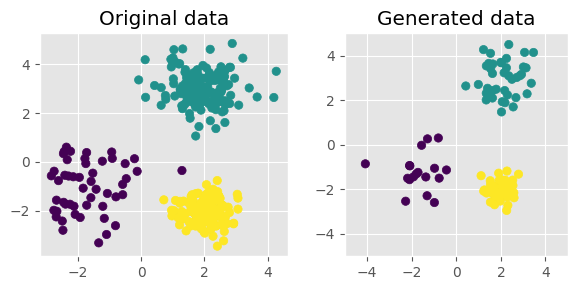

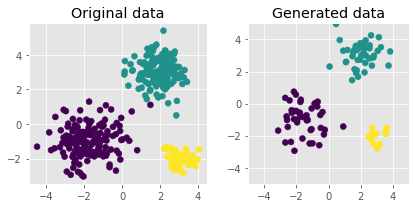

In [ ]:
estimated_pi, estimated_mu, estimated_Sigma = model.pi, model.mu, model.sigma
x_generated, y_generated = generate_from_nbc(estimated_pi, estimated_mu, estimated_Sigma, 100)

fig, ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].scatter(x_train[:,0], x_train[:,1], c=y_train)
ax[0].set_title("Original data")

ax[1].scatter(x_generated[:,0], x_generated[:,1], c=y_generated)
ax[1].set_title("Generated data")
fig.tight_layout()
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

This implies that our NBC model, although it is mainly used to predict labels, is also able to capture data distributions.